In [1]:
import pandas as pd
import torch
import numpy as np
                
from dist_ae import SetAutoencoderGNN, SetAutoencoderHybrid, train_w_stop
from losses import sliced_wasserstein_distance, sinkhorn, mmd

from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/Preprocessed_viral_proteomes.csv', index_col=0)
df['Embedding'] = [eval(x) for x in df['Embedding'].values]

In [3]:
def sample_organism_embeddings(df, m):
    grouped = df.groupby("Organism")["Embedding"].apply(list).to_dict()
    tensors, metadata = [], {}

    for i, (org, embs) in enumerate(grouped.items()):
        embs = np.stack(embs)  # ensure it's a proper (N, embedding_dim) array
        sampled_embs = embs[np.random.choice(len(embs), m, replace=len(embs) < m)]  # sample along axis 0
        tensors.append(torch.tensor(sampled_embs, dtype=torch.float32))
        metadata[i] = org  # index -> organism mapping

    return torch.stack(tensors), metadata  # (N_organism, m, embedding_dim), metadata dict

In [4]:
m = 50
sets, names = sample_organism_embeddings(df, m)

In [5]:
train_loader = torch.utils.data.DataLoader(sets, 
                                           batch_size=32, shuffle=True)

val_loader = torch.utils.data.DataLoader(sets[:1], 
                                           batch_size=32, shuffle=False)

def loss_fn(X, Y):
    return torch.vmap(sliced_wasserstein_distance, randomness='different')(X, Y).mean()

dist_ae = SetAutoencoderGNN(sets.shape[2], 32, 128, m)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

dist_ae = train_w_stop(dist_ae, optimizer, train_loader, val_loader, 
                       loss_fn, max_epochs=300, patience=300)

Epoch 1 | Train Loss: 0.0571 | Val Loss: 0.0320
Epoch 2 | Train Loss: 0.0355 | Val Loss: 0.0293
Epoch 3 | Train Loss: 0.0341 | Val Loss: 0.0321
Epoch 4 | Train Loss: 0.0339 | Val Loss: 0.0289
Epoch 5 | Train Loss: 0.0338 | Val Loss: 0.0321
Epoch 6 | Train Loss: 0.0333 | Val Loss: 0.0282
Epoch 7 | Train Loss: 0.0326 | Val Loss: 0.0256
Epoch 8 | Train Loss: 0.0319 | Val Loss: 0.0275
Epoch 9 | Train Loss: 0.0317 | Val Loss: 0.0268
Epoch 10 | Train Loss: 0.0311 | Val Loss: 0.0267
Epoch 11 | Train Loss: 0.0309 | Val Loss: 0.0254
Epoch 12 | Train Loss: 0.0305 | Val Loss: 0.0260
Epoch 13 | Train Loss: 0.0303 | Val Loss: 0.0249
Epoch 14 | Train Loss: 0.0301 | Val Loss: 0.0256
Epoch 15 | Train Loss: 0.0298 | Val Loss: 0.0270
Epoch 16 | Train Loss: 0.0298 | Val Loss: 0.0244
Epoch 17 | Train Loss: 0.0294 | Val Loss: 0.0253
Epoch 18 | Train Loss: 0.0295 | Val Loss: 0.0238
Epoch 19 | Train Loss: 0.0293 | Val Loss: 0.0255
Epoch 20 | Train Loss: 0.0290 | Val Loss: 0.0247
Epoch 21 | Train Loss: 0.0291

In [6]:
with torch.no_grad():
    z, rec = dist_ae((sets).float().cuda())

In [7]:
umap = UMAP(n_components=2)
vis = umap.fit_transform(z.cpu().numpy())

/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


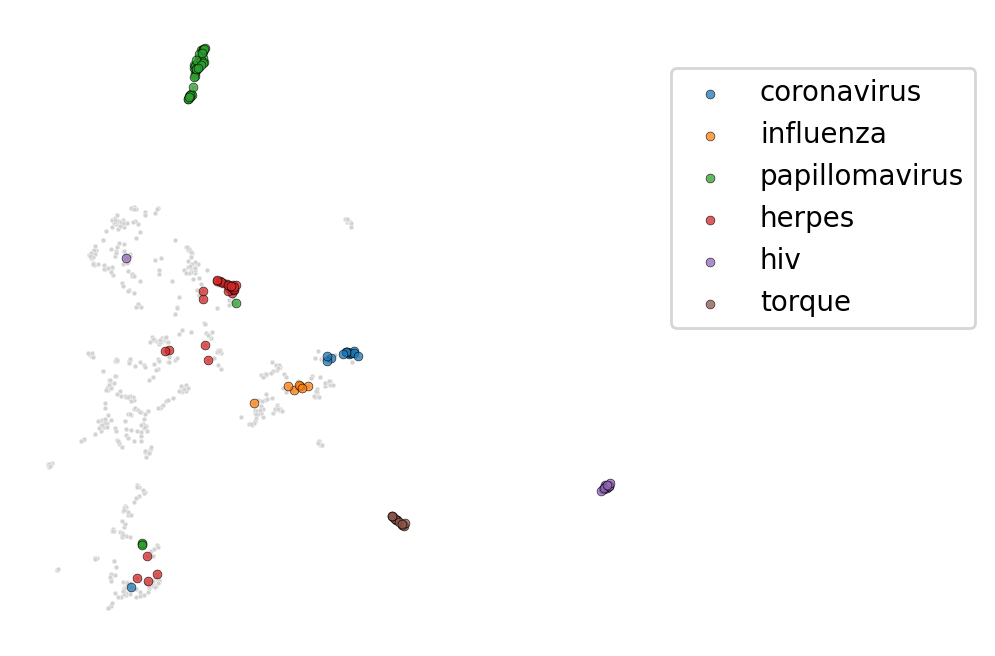

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig = plt.figure(figsize=(4,4), dpi=200)

# plot all points in light gray
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], color="lightgray", s=3)

# plot points for each keyword with distinct colors
keywords = ["coronavirus", "influenza", "papillomavirus", 
            "herpes", "hiv", "torque"]
colors = sns.color_palette("tab10", len(keywords))

for idx, keyword in enumerate(keywords):
    mask = np.array([keyword in names[i].lower() for i in range(len(names))])
    sns.scatterplot(x=vis[mask, 0], y=vis[mask, 1], alpha=0.75, 
                    color=colors[idx], s=10, label=keyword, edgecolor='black')

plt.axis('off')
plt.legend(loc=(1.05, 0.5))
plt.show()


In [25]:
names

{0: 'Abutilon mosaic virus (isolate West India) (AbMV)',
 1: 'Acanthamoeba polyphaga mimivirus (APMV)',
 2: 'Acholeplasma phage L2 (Bacteriophage L2)',
 3: 'Acidianus bottle-shaped virus (isolate Italy/Pozzuoli) (ABV)',
 4: 'Acidianus filamentous virus 1 (isolate United States/Yellowstone) (AFV-1)',
 5: 'Acidianus filamentous virus 2 (isolate Italy/Pozzuoli) (AFV-2)',
 6: 'Acidianus two-tailed virus (ATV)',
 7: 'Acinetobacter phage Ac42 (Acinetobacter phage 42)',
 8: 'Acinetobacter phage SH-Ab 15497',
 9: 'Acute bee paralysis virus (strain Rothamsted) (ABPV)',
 10: 'Acyrthosiphon pisum secondary endosymbiont phage 1 (Bacteriophage APSE-1)',
 11: 'Adeno-associated virus 2 (isolate Srivastava/1982) (AAV-2)',
 12: 'Adoxophyes honmai nucleopolyhedrovirus',
 13: 'Aedes albopictus densovirus (isolate Boublik/1994) (AalDNV)',
 14: 'Aedes pseudoscutellaris reovirus (isolate France) (ApRV)',
 15: 'African cassava mosaic virus (isolate Nigerian) (ACMV) (Cassava latent virus (isolate Nigerian))',